In [1]:
import numpy as np
import pandas as pd
import h5py
import math
import tensorflow as tf
from tensorflow.python.framework import ops
import matplotlib.pyplot as plt
%matplotlib inline

/home/mrigank/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/mrigank/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/mrigank/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/mrigank/anaconda3/lib/python3.6/site-packages/tensorflow/python/

In [2]:
def load_dataset():
    train_dataset = h5py.File('datasets/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('datasets/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [3]:
x_train,y_train,x_test,y_test,classes=load_dataset()

In [4]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)

(209, 64, 64, 3)
(1, 209)
(50, 64, 64, 3)


The label of the image is : [1]


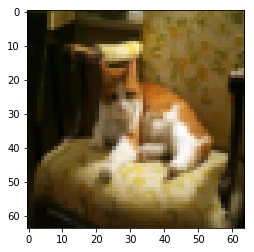

In [5]:
plt.imshow(x_train[7,])
print("The label of the image is : "+str(y_train[:,7]))

In [6]:
x_train=x_train.reshape(x_train.shape[0],-1).T
x_test=x_test.reshape(x_test.shape[0],-1).T
print ("sanity check after reshaping: " + str(x_train[0:5,0]))

sanity check after reshaping: [17 31 56 22 33]


In [7]:
x_train=x_train/255
x_test=x_test/255

In [8]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

In [9]:
y_train=convert_to_one_hot(y_train,2)
y_test=convert_to_one_hot(y_test,2)

In [10]:
y_train.shape

(2, 209)

In [11]:
def create_placeholders(n_x,n_y):
    x=tf.placeholder(tf.float32,shape=[n_x,None],name='x')
    y=tf.placeholder(tf.float32,shape=[n_y,None],name='y')
    return x,y

In [12]:
def initialize_parameters():
    W1=tf.get_variable('W1',shape=[20,12288],initializer=tf.contrib.layers.xavier_initializer(seed=1))
    b1=tf.get_variable('b1',shape=[20,1],initializer=tf.zeros_initializer())
    W2=tf.get_variable('W2',shape=[7,20],initializer=tf.contrib.layers.xavier_initializer(seed=1))
    b2=tf.get_variable('b2',shape=[7,1],initializer=tf.zeros_initializer())
    W3=tf.get_variable('W3',shape=[5,7],initializer=tf.contrib.layers.xavier_initializer(seed=1))
    b3=tf.get_variable('b3',shape=[5,1],initializer=tf.zeros_initializer())
    W4=tf.get_variable('W4',shape=[2,5],initializer=tf.contrib.layers.xavier_initializer(seed=1))
    b4=tf.get_variable('b4',shape=[2,1],initializer=tf.zeros_initializer())
    parameters={'W1':W1,'b1':b1,'W2':W2,'b2':b2,'W3':W3,'b3':b3,'W4':W4,'b4':b4}
    return parameters

In [13]:
def forward_propagation(x,parameters):
    W1=parameters['W1']
    W2=parameters['W2']
    W3=parameters['W3']
    W4=parameters['W4']
    b1=parameters['b1']
    b2=parameters['b2']
    b3=parameters['b3']
    b4=parameters['b4']
    Z1=tf.add(tf.matmul(W1,x),b1)
    A1=tf.nn.relu(Z1)
    Z2=tf.add(tf.matmul(W2,A1),b2)
    A2=tf.nn.tanh(Z2)
    Z3=tf.add(tf.matmul(W3,A2),b3)
    A3=tf.nn.relu(Z3)
    Z4=tf.add(tf.matmul(W4,A3),b4)
    A4=tf.sigmoid(Z4)
    return A4

In [14]:
def compute_cost(A4,Y):
    logits = tf.transpose(A4)
    labels = tf.transpose(Y)
    cost=tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits,labels=labels))
    return cost

In [15]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    m = X.shape[1]          
    mini_batches = []
    np.random.seed(seed)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((Y.shape[0],m))
    num_complete_minibatches = math.floor(m/mini_batch_size)
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    return mini_batches

In [16]:
def model(X_train,Y_train,X_test,Y_test,learning_rate=0.0075,num_epochs=2500,minibatch_size=32):
    ops.reset_default_graph()           
    tf.set_random_seed(1)                             
    seed = 3                                          
    (n_x, m) = X_train.shape                          
    n_y = Y_train.shape[0]
    costs=[]
    x,y=create_placeholders(n_x,n_y)
    parameters=initialize_parameters()
    A4=forward_propagation(x,parameters)
    cost=compute_cost(A4,y)
    optimizer=tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost)
    init=tf.global_variables_initializer()
    with tf.Session() as sess:
        sess.run(init)
        for epochs in range(num_epochs):
            epoch_cost=0
            num_minibatches=int(m/minibatch_size)
            seed=seed+1
            mini_batches=random_mini_batches(X_train,Y_train,minibatch_size,seed)
            for mini_batch in mini_batches:
                (minibatch_x,minibatch_y)=mini_batch
                _,minibatch_cost=sess.run([optimizer,cost],feed_dict={x:minibatch_x,y:minibatch_y})
                epoch_cost += minibatch_cost /num_minibatches
            if epochs % 100 == 0:
                print ("Cost after epoch %i: %f" % (epochs, epoch_cost))
            if epochs % 5 == 0:
                costs.append(epoch_cost)
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
        parameters=sess.run(parameters)
        print("Parameters have been trained")
        correct_prediction = tf.equal(tf.argmax(A4), tf.argmax(y))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print ("Train Accuracy:", accuracy.eval({x: X_train, y: Y_train}))
        print ("Test Accuracy:", accuracy.eval({x: X_test, y: Y_test}))
        return parameters

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.

Cost after epoch 0: 0.814367
Cost after epoch 100: 0.754089
Cost after epoch 200: 0.623700
Cost after epoch 300: 0.481029
Cost after epoch 400: 0.414202
Cost after epoch 500: 0.407900
Cost after epoch 600: 0.391240
Cost after epoch 700: 0.388176
Cost after epoch 800: 0.386467
Cost after epoch 900: 0.385368
Cost after epoch 1000: 0.384663
Cost after epoch 1100: 0.384105
Cost after epoch 1200: 0.383674
Cost after epoch 1300: 0.383379
Cost after epoch 1400: 0.383134
Cost after epoch 1500: 0.382928
Cost after epoch 1600: 0.382755
Cost after epoch 1700: 0.382617
Cost after epoch 1800: 0.382492
Cost after epoch 1900: 0.386971
Cost after epoch 2000: 0.382313
Cost after epoch 2100: 0.382216
Cost after epoch 2200: 0.382134
Cost after epoch 2300: 0.382082
Cost after epoch 2400: 0.382033


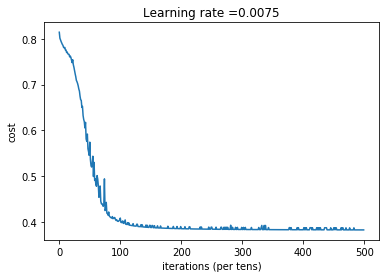

Parameters have been trained
Train Accuracy: 0.98564595
Test Accuracy: 0.78


In [17]:
parameters=model(x_train,y_train,x_test,y_test)